# Part 1: Implementation

## PCA

### import module

In [46]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

### Obtain data

In [2]:
data = pd.read_csv("pca-data.txt", header = None, sep="\t")

In [3]:
data.head()

,0,1,2
0,5.906263,-7.729465,9.144945
1,-8.640323,1.724260,-10.696805
2,0.258541,0.230622,0.767439
3,-5.234354,3.194685,-1.894385
4,12.622863,-3.507888,4.086258


### Calculate the mean of each attribute

In [4]:
mu = np.mean(data, axis = 0)
mu

0    0.046416
1   -0.035627
2    0.063343
dtype: float64

In [5]:
for i in range(data.shape[0]):
    data.iloc[i, :] -= mu

In [6]:
data = np.mat(data)
data

matrix([[  5.85984677,  -7.69383808,   9.08160172],
        [ -8.68673919,   1.75988694, -10.76014834],
        [  0.21212453,   0.26624874,   0.70409601],
        ...,
        [ -3.737844  ,  -0.4387115 ,   0.48685742],
        [  7.59189921,  -4.44020641,   8.09057975],
        [  9.67566148,  -8.46572792,   8.77906364]])

In [7]:
Sigma = (data.T * data)/data.shape[0]
Sigma

matrix([[ 81.22845778, -15.83817402,  31.66312677],
        [-15.83817402,  13.69953054, -15.26190629],
        [ 31.66312677, -15.26190629,  31.36154358]])

In [8]:
eigenvale, eigenvetor = np.linalg.eig(Sigma)
eigenvale, eigenvetor

(array([101.60286375,  19.89589866,   4.79076949]),
 matrix([[ 0.86667137, -0.4962773 , -0.0508879 ],
         [-0.23276482, -0.4924792 ,  0.83862076],
         [ 0.44124968,  0.71496368,  0.54233352]]))

In [9]:
newData = list()
for i in range(data.shape[0]):
    newData.append((eigenvetor[:, :2].T * data[i].T).T.tolist()[0])

In [10]:
newData[:6]

[[10.876670088473485, 7.373961725406449],
 [-12.686099923349113, -4.248791513451973],
 [0.43255105670676064, 0.26700851768589956],
 [-6.192441742914561, -0.3698393847269761],
 [13.482976696234925, -1.655150407611496],
 [-0.09484157859795038, -1.909424282377106]]

## Fastmap

### Obtain data

In [11]:
data = pd.read_csv("fastmap-data.txt", header = None, sep="\t")

In [12]:
data.head()

,0,1,2
0,1,2,4
1,1,3,7
2,1,4,6
3,1,5,7
4,1,6,7


### Obtain original distance

In [15]:
def get_original_distance(data):
    original_distance = np.zeros((10, 10))
    for index, row in data.iterrows():
        point_a = row[0]
        point_b = row[1]

        original_distance[point_a - 1][point_b - 1] = original_distance[point_b - 1][point_a - 1] = row[2]
    
    return original_distance

### Identify farthest pair $O_{a}$, $O_{b}$

In [23]:
def get_single_distance(distance, coordinate, k, point_i, point_j):
    
    if k == 1:
        return distance[point_i][point_j]
    
    n = 1
    new_single_distance = pow(distance[point_i][point_j], 2)

    while(n < k):
        new_single_distance -= pow(coordinate[n - 1][point_i] - coordinate[n - 1][point_j], 2)
        n += 1
    
    return np.sqrt(new_single_distance)

In [24]:
def farthest_pair(distance, coordinate, k):
    point_a = random.randint(0, 9)
    farthest_distance = -1
    farthest_point = -1
    temp_point = -1
    
    while True:
        for i in range(10):
            new_single_distance = get_single_distance(distance, coordinate, k, point_a, i)
            if new_single_distance > farthest_distance:
                farthest_point = i
                farthest_distance = new_single_distance
        if farthest_point == temp_point:
            break
        temp_point = point_a
        point_a = farthest_point
        farthest_distance = -1
        farthest_point = -1
    
    return [point_a, farthest_point] if point_a < farthest_point else [farthest_point, point_a]

### Calculate the coordinate

In [35]:
def get_coordinate(distance, coordinate, k, point_a, point_b):
    new_coordinate = list()
    
    for i in range(10):
        distance_a_i = get_single_distance(distance, coordinate, k, point_a, i)
        distance_a_b = get_single_distance(distance, coordinate, k, point_a, point_b)
        distance_b_i = get_single_distance(distance, coordinate, k, point_b, i)
        
        new_coordinate.append((pow(distance_a_i, 2) +
                        pow(distance_a_b,2) - 
                        pow(distance_b_i, 2))/(2 * distance_a_b))
    
    coordinate.append(new_coordinate)
    
    return coordinate

### Implement fastmap

In [41]:
def fastmap(dimension):
    
    k = 1
    original_distance = get_original_distance(data)
    coordinate = list()
    
    while k <= dimension:
        [point_a, point_b] = farthest_pair(original_distance, coordinate, k)
        coordinate = get_coordinate(original_distance, coordinate, k, point_a, point_b)
        k += 1
    
    return coordinate

In [45]:
coordinate = fastmap(2)
coordinate

[[3.875,
  3.0,
  0.0,
  1.0416666666666667,
  2.4583333333333335,
  9.5,
  2.4583333333333335,
  1.5,
  2.4583333333333335,
  12.0],
 [6.0625,
  7.749999999999999,
  4.0,
  1.1875,
  0.0,
  5.1875,
  8.0,
  1.5624999999999996,
  1.0,
  4.0]]

### Plot the words on a 2D plane

In [68]:
label = pd.read_csv("fastmap-wordlist.txt", header = None)[0]

In [71]:
def plot_fastmap_result(coordinate, label):
    
    fig,ax=plt.subplots()
    coordinate1 = coordinate[0]
    coordinate2 = coordinate[1]
    ax.scatter(coordinate1, coordinate2)


    for i,txt in enumerate(label):
        ax.annotate(txt,(coordinate1[i],coordinate2[i]))

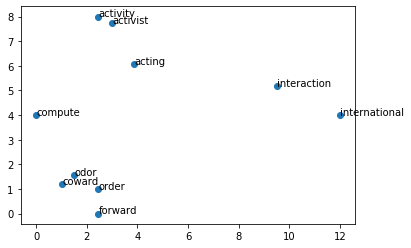

In [72]:
plot_fastmap_result(coordinate, label)

# Part 2: Software Familiarization

## PCA

In [73]:
from sklearn.decomposition import PCA 

In [74]:
data = pd.read_csv("pca-data.txt", header = None, sep="\t")

In [77]:
pca=PCA(n_components=2)
newData=pca.fit_transform(data)
newData

array([[-10.87667009,   7.37396173],
       [ 12.68609992,  -4.24879151],
       [ -0.43255106,   0.26700852],
       ...,
       [  2.92254009,   2.41914881],
       [-11.18317124,   4.20349275],
       [-14.2299014 ,   5.64409544]])